In [519]:
import numpy as np
import math
import copy
import numpy.linalg as LA
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from tqdm import tqdm
from scipy.fft import dct
import scipy

# Classification

In [520]:
ambientDimension = 128
# sigma = 0.25 # noise power
numAvg = int(1 * 1e+0) # number of experiment average
num_sample = 32
max_d = ambientDimension
num_para_list = [int(x) for x in np.linspace(1, ambientDimension, 20)]

# Data generation model:
featureMean = np.zeros(ambientDimension)
DCT = dct(np.identity(ambientDimension), axis=0, norm='ortho')
# 1. betaStar has most of its energy concentrated at the first 20 dct components
betaStar = 0
eff_dim = 20
coef = 0.02 + np.zeros(ambientDimension)
for i in range(eff_dim):
    coef[i] = np.sqrt((1 - (0.02 ** 2) * (ambientDimension - eff_dim)) / eff_dim)
for i in range(ambientDimension):
    betaStar += coef[i] * DCT[:,i]
betaStar = betaStar.reshape(-1,1)
# 2. input data distribution
Sigma = np.identity(ambientDimension)
decay = .9
snr = 1
for i in range(ambientDimension):
    Sigma[i, i] = decay ** (i - 1)
featureCov = DCT.dot(Sigma).dot(DCT.T)
leading_factor = (LA.norm(betaStar))**4 / betaStar.T.dot(featureCov).dot(betaStar)[0][0] / snr
featureCov = leading_factor * featureCov




# Training model
# cosine dct model (perfect model)
U = DCT
# hadamard model (misspecified model)
#U = scipy.linalg.hadamard(ambientDimension)
#U = U / np.sqrt(ambientDimension)


In [521]:
# Estimator Function
def get_ridge_est(X, y, ridge):
    d = X.shape[1]
    n = X.shape[0]
    idm = np.identity(d)
    S = LA.pinv(X.T.dot(X) + n * ridge * idm).dot(X.T)
    return S.dot(y)

def get_lse_est(X, y):
    Cov = X.T.dot(X)
    #d = X.shape[1]
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y)

def get_crop_est(X, y, p):
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    a = 0
    Z = a * Cov + (1 - a) * ((1-p) * Cov + p * diag)
    S = LA.pinv(Z).dot((1 - p) * X.T)
    return S.dot(y)

# Risk

def get_risk(beta):
    z = np.inner(beta.reshape(-1), betaStar.reshape(-1)) / math.sqrt(2) / math.sqrt(beta.T.dot(featureCov).dot(beta)[0])
    #print(z, LA.norm(beta), np.inner(beta.reshape(-1), betaStar.reshape(-1)), math.sqrt(beta.T.dot(featureCov).dot(beta)[0]))
    return 0.5 * (1 - math.erf(z))

def get_exp_risk(para_ridge_list, para_crop_list):
    risk_ridge = np.zeros([len(num_para_list), len(para_ridge_list)])
    risk_crop = np.zeros([len(num_para_list), len(para_crop_list)])
    riskLSE = np.zeros(len(num_para_list))
    Z = np.zeros([num_sample, ambientDimension])
    y = np.zeros([num_sample, 1])
    for i in range(num_sample):
        z = random.random()
        y[i, 0] = -1 if z <= 0.5 else 1
        Z[i, :] = (betaStar * y[i, 0] + np.random.multivariate_normal(np.zeros(ambientDimension), featureCov).reshape(-1, 1)).reshape(-1)
        feature = Z.dot(U)
    for idx, t in enumerate(num_para_list):
        X = feature[:,:t+1]
        # baseline LSE
        beta_est = get_lse_est(X, y)
        riskLSE[idx] = get_risk(U[:,:t+1].dot(beta_est))
        
        for j in range(len(para_ridge_list)):
            beta_est = get_ridge_est(X, y, para_ridge_list[j])
            risk_ridge[idx, j] = get_risk(U[:,:t+1].dot(beta_est))
        for j in range(len(para_crop_list)):
            beta_est = get_crop_est(X, y, para_crop_list[j])
            risk_crop[idx, j] = get_risk(U[:,:t+1].dot(beta_est))
    return risk_ridge, risk_crop, riskLSE

In [522]:
# Choose the type of augmentation:

# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
ridge_params = np.power(2, np.linspace(-10, 20, num=10))
crop_params = np.concatenate((np.linspace(0, 0.4, num=4), np.linspace(.5, .99, num=5)))


In [523]:
risk_ridge = np.zeros([len(num_para_list), len(ridge_params)])
risk_crop = np.zeros([len(num_para_list), len(crop_params)])
risk_lse = np.zeros(len(num_para_list))

# Simulate risk
avg_num = int(1e+1)
np.random.seed(1)
start = time.time()
for i in tqdm(range(avg_num)):
    a, b, c = get_exp_risk(ridge_params, crop_params)
    risk_ridge += a
    risk_crop += b
    risk_lse += c
risk_ridge /= avg_num
risk_crop /= avg_num
risk_lse /= avg_num
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

  0%|          | 0/10 [00:00<?, ?it/s]

0.09508112510249335 0.35628286552332183 0.07010485489035417 0.5213612926186166
0.09507179549703575 0.3560937814080774 0.07006083356568822 0.521085041582336
0.09498746559200141 0.3543864663379906 0.06966361203286348 0.5185906599716091
0.09417380086903694 0.3380769014081045 0.06589335088377409 0.4947621824228673
0.0885236236675594 0.23182104237307963 0.04250058296620804 0.3394850908119826
0.07806455100167813 0.05651343244428057 0.009152512800213033 0.08290323562852733
0.07490447712828366 0.006580057933627806 0.0010231709120736444 0.009658849750743551
0.07452690642508084 0.0006643418495963776 0.00010278972939759843 0.0009752627363707619
0.07448868816505545 6.602672097001018e-05 1.0210771634890952e-05 9.69288900373705e-05
0.0744848888173435 6.551821154984205e-06 1.0131623963217356e-06 9.618246227622716e-06
0.07448451179919335 6.500342179957701e-07 1.00519676756848e-07 9.542674491721212e-07
0.09508112510249334 0.3562828655233218 0.07010485489035415 0.5213612926186165
0.09297843962524238 0.3

 10%|█         | 1/10 [00:01<00:09,  1.05s/it]

0.5043268561223784 0.00013940931422410445 0.00010465417166028382 0.00014673355892530672
0.504315238055146 1.3834863641016768e-05 1.0385841629471739e-05 1.4562120059766994e-05
0.5043140851929115 1.3726288279300691e-06 1.0304338877631662e-06 1.4447877047158745e-06
0.32094201045678283 1.7667087909661017 0.49732851862248206 1.0957255720275092
7.973500712809525 6.937109994927565 0.96939908280786 0.08596834562618695
8.074785921724649 6.8604661512600185 0.9635103156801745 0.08437433321020185
8.172875888889752 6.764688082398287 0.9553618923589919 0.0826566904671331
8.241124286149965 6.672813599879546 0.9467801052680898 0.0812358374272669
8.310795259663022 6.5191451867656784 0.9309541870004596 0.07920830655004316
8.347107032772056 6.271715341040876 0.9024133570092414 0.07644595926100625
8.304587569996933 5.734564041866776 0.8327083129593045 0.07090221999358741
8.051565685881625 1.9697076783884433 0.2893079505185153 0.025407681144741755
0.3258953061902572 1.7598050816933215 0.5012118867043296 1.

 20%|██        | 2/10 [00:02<00:08,  1.02s/it]

8.046708041889106 6.631527894031713 0.9438570745355377 0.08294171161680294
8.105277278680175 6.554753744247263 0.9365118783001507 0.08170157257292733
8.143694569912205 6.479240817231881 0.9287497165606542 0.08064217253818282
8.180363788963385 6.349109473006282 0.9143121705228239 0.07903271206230868
8.196756005217969 6.130720093242192 0.8878167679894307 0.0765889891924087
8.171041964591293 5.630626869521454 0.8212178794903502 0.07106666860060717
8.040880896232647 1.9308673687525504 0.2843860504479202 0.025008616262529176
0.5322137375405311 2.095408576360988 0.6242971090406213 0.8294500651519959
0.5332350123484781 2.043667990028761 0.620285149855214 0.8225413290102901
0.5392596227275649 1.7324669270615722 0.5945936925075935 0.779663847065509
0.5676742361243612 1.0049387969460437 0.5177135165002186 0.6448746744762267
0.5285098645633426 0.4355623354368157 0.3135829273785814 0.41955056902660354
0.509237899426202 0.09686890568410435 0.07392019079419941 0.1026425335507783
0.5077350686622631 0

 30%|███       | 3/10 [00:03<00:08,  1.14s/it]

0.47632463389300733 0.10878770246826978 0.0777044883507059 0.11535277987272252
0.4640660750422698 0.013182991738366512 0.009422929752162978 0.014357906954935263
0.4626202138899334 0.0013383723508138437 0.0009565953285244841 0.0014621389713246912
0.46247390212955175 0.00013309205658225748 9.512630890417409e-05 0.0001454448732904827
0.4624593572200969 1.3207452017774474e-05 9.439897240941442e-06 1.4433734010483115e-05
0.46245791389665464 1.3103752084732926e-06 9.365778117233716e-07 1.4320449534494263e-06
0.5073168002007923 1.7631989505542007 0.6460032866141328 0.9004103638059189
7.931263207330206 6.696842201595231 0.962714110534924 0.0858301708199606
8.016101399337558 6.643213682540033 0.956878222900643 0.08440700116875918
8.087971645787782 6.57426779619047 0.9489092275025637 0.08296024997157325
8.13278636827473 6.505504994659517 0.9405780173239129 0.08177874890199867
8.174378571937137 6.384446238249141 0.925260859527532 0.08003767165671745
8.194159224521163 6.17542869037843 0.8975688254

 40%|████      | 4/10 [00:04<00:07,  1.20s/it]

0.329795438108129 1.798114224297828 0.3724017448197883 0.7984579792805929
0.456606805982879 0.8961142902368473 0.35750355213521556 0.5536342925702429
0.4995062929483943 0.3929816247593536 0.27022104019888904 0.3825279734036458
0.4363487254909892 0.11533301409109112 0.08519419840975404 0.13805791536460732
0.4153418707447375 0.015572504397445083 0.011341231427448965 0.01930809825403754
0.4128410125564656 0.0016056607749680668 0.0011666055007806446 0.0019981412589397127
0.4125879755165687 0.00015992837494047091 0.00011616840302726203 0.00019909321263505926
0.41256282163368174 1.5873102803827112e-05 1.1529582502854156e-05 1.9760980739211516e-05
0.4125603255648884 1.5748722967611758e-06 1.1439209913105648e-06 1.960620641332407e-06
0.28721859263882304 2.280503047094661 0.39139364893834827 0.9635765593548279
9.306239949449026 6.4516910362785795 0.9591334926530193 0.07287688694919593
9.429976673263624 6.369620069455437 0.9532516696317543 0.07147957446014865
9.517135975231692 6.276999390521922 

 50%|█████     | 5/10 [00:06<00:06,  1.27s/it]

8.861336280043371 6.804341516471137 0.9689550180408855 0.07731956470995029
9.04116954595138 6.677987924206955 0.9631823389577607 0.07533016164940028
9.185832224099105 6.541262786518198 0.9555450261131808 0.073555922992048
9.266223360810764 6.425957710790704 0.9477498715672317 0.07232292326215112
9.323051014802981 6.255522856534777 0.9336848199498462 0.07081532286256922
9.317688149026454 6.012907563898208 0.9085979203658192 0.06895227019695799
9.215005709197248 5.5307664382776105 0.8467303153646044 0.0649732367754217
8.923392449595699 2.0396320355019855 0.31680781165699334 0.0251044603519237
0.1453568461948817 0.24056012936403254 0.07439301272467895 0.36189422891021616
0.1453556727884725 0.24046571016957968 0.07436363779302815 0.3617542511304076
0.14534501282128087 0.239612208022331 0.07409807331027347 0.36048880586620846
0.1452374542358744 0.23136961813236298 0.07153092990156096 0.34825731326733633
0.14432767594857546 0.17286593897962335 0.05326375076623266 0.26095590544708014
0.142383

 60%|██████    | 6/10 [00:07<00:04,  1.25s/it]

9.202510822840635 6.276907653428368 0.9558410629950624 0.0734453575107815
9.24507908797541 6.215429988329301 0.9490857186031947 0.07259050367935709
9.274748356382394 6.110747045976402 0.9363537911626623 0.07138760965576246
9.272121521621692 5.934160897920706 0.912689509157883 0.06960315819183588
9.221935427619808 5.518008675684669 0.8522471239508096 0.06534742357742673
9.086400517608965 2.059055126792532 0.3196365103267732 0.024874222034220916
0.13524864497615052 0.11473464016443007 0.033511750637470694 0.1752060889731406
0.1352521018717441 0.11467848006775846 0.03349611552620522 0.1751198695192764
0.13528333768231127 0.11417115365252842 0.033354840950675646 0.17434101365097654
0.1355837024307939 0.10930353566392464 0.03199627158517487 0.1668694703341058
0.13761553495589254 0.07666585650536777 0.022739461793968525 0.11684166064682412
0.14106506865110804 0.019401715935464588 0.005876656975505495 0.029457498144807526
0.14199939007098733 0.002284961104782255 0.000695769678773989 0.0034646

 70%|███████   | 7/10 [00:08<00:03,  1.14s/it]

0.5636081847976157 2.481889029694691 0.8749673405806535 1.0977401615689895
7.843629462683135 6.806691972696065 0.9502875790601457 0.085668859604813
7.972039302081384 6.73239358426178 0.94570535415446 0.08388251030730022
8.087365723282115 6.641527052799003 0.9390936601754438 0.08210825601316603
8.162960462299274 6.555326530914915 0.9318875642454048 0.08072365645095067
8.23754328845152 6.411740221142122 0.9181513313054079 0.07881367172075303
8.28116245569903 6.179574458331048 0.8924275419719689 0.07620205134506733
8.268323286705902 5.6667837084144175 0.8268324514777394 0.07071068862111879
8.1283546521473 1.9536113464435712 0.2889136903049251 0.025133355806303773
0.5731925091419471 2.4638417744995453 0.8768488868899575 1.0817060308829332
0.5762558629127833 2.372767883544988 0.8651561380858187 1.0616078922536487
0.588705394839682 1.886076232743363 0.7855957338087696 0.9435960253068145
0.5901046141689397 1.0166762550288087 0.5453585570231911 0.6534887621448232
0.5561982393288865 0.409510886

 80%|████████  | 8/10 [00:09<00:02,  1.13s/it]

0.6118078741327957 1.3480425865699104 0.7436681989666178 0.8595064703726637
0.6199636865467304 1.2360784774568467 0.7283224576858529 0.8306966357799733
0.6451763557962983 0.8727427524391473 0.6388034470333002 0.7001221374349375
0.6344684172826668 0.44553247763906834 0.3729921300018025 0.4156948671819951
0.5716225718897644 0.10947264621263697 0.09044896199826194 0.11188689447447026
0.548640315867994 0.013304790583078546 0.010784389820582115 0.013899297868820085
0.5457897779531692 0.0013515346822285349 0.0010925893464393411 0.0014155218128429775
0.5455000181332528 0.00013440933643549607 0.00010862756389578825 0.00014080895417261684
0.5454712002903866 1.3338255866855086e-05 1.0779479255890744e-05 1.3973685275120469e-05
0.5454683405073538 1.3233537083512067e-06 1.069482045212122e-06 1.386401281921061e-06
0.6107444003462172 1.3635371498192834 0.7455786659852851 0.8632150050452448
7.997519486165338 6.694954031807022 0.9632438983519582 0.08516594347028189
8.083381843714816 6.630935640531588 0

 90%|█████████ | 9/10 [00:10<00:01,  1.09s/it]

8.562054625656366 5.693461068400534 0.8210906320875186 0.06781068088237342
8.245003425065608 1.9307926470632373 0.28333305608663356 0.02429916823128218
0.3261550339797443 2.50122204418751 0.5728654629270452 1.2419770089105584
0.3313971483879658 2.4399961470233555 0.5690910136092469 1.214277542196368
0.3680001671778957 2.033653010128601 0.5387568256057257 1.035213129705419
0.4968781617635811 0.9763116323372881 0.41675841878995173 0.5930884605533846
0.6220348932810247 0.3897802305528207 0.2697503003910671 0.3066423904735159
0.612195405981078 0.10722246871633288 0.08506884122114727 0.09825744183551446
0.58410648518462 0.013998626796605889 0.011140565331657415 0.013486529412144488
0.5799626397648423 0.0014373130291134297 0.0011430364845592422 0.001393622267984699
0.5795336069569114 0.0001430993470737465 0.00011379117070221383 0.00013884010776388646
0.5794908594952466 1.4202196613463244e-05 1.1293345433129734e-05 1.3780374629211328e-05
0.579486616612557 1.409085045057528e-06 1.1204795055946

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

6.736859376624937 6.861628804400173 0.9368070501825754 0.098328105251223
6.837133833891407 6.700458940283372 0.9181463552318734 0.09495609266678016
6.90908441051181 6.434781062362688 0.8850595945575456 0.09058098061643112
6.928452916377563 5.835905393232507 0.80586969937323 0.08224576771425986
6.833159521385199 1.81823674454949 0.2521358313314503 0.026091437724614138
0.5125405403112396 1.9487957997155951 0.7496291089798517 1.0341968774071988
0.5140395094905826 1.9207005463259639 0.7469121438453354 1.027443673321952
0.5244727020177234 1.7316895868987239 0.7237776273022272 0.9758145016272357
0.5763320408507132 1.098629622268645 0.5922552187970032 0.7266430663586193
0.6011246685716626 0.4160685801489914 0.31071258892772147 0.3654931998596358
0.5458710035299994 0.09482500397120552 0.07483840205924636 0.0969436757897878
0.5285014164348524 0.01155250777086034 0.009021715112666709 0.012070574904289129
0.5262950394387172 0.0011746628758036413 0.0009156149881861305 0.0012301798774180586
0.52606

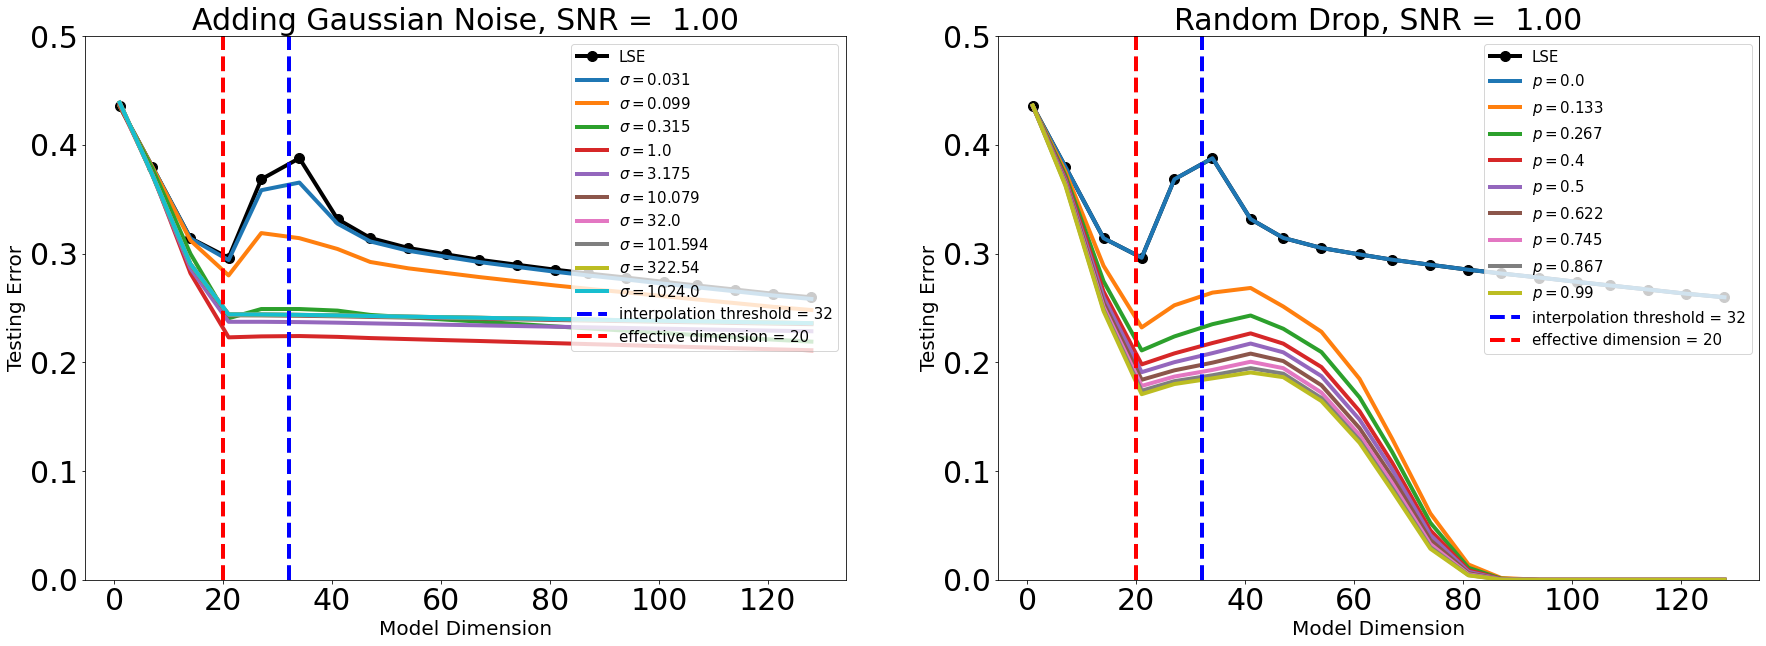

In [534]:
import seaborn as sns

plt.figure(figsize=(30, 10))
plt.subplot(1,2,1)
x_ax = num_para_list
plt.plot(x_ax, risk_lse, label="LSE", color='black', marker='o', markersize=10, linewidth=4.0)
for i in range(len(ridge_params)):
    plt.plot(x_ax, risk_ridge[:,i], label=r'$\sigma=$'+str(round(np.sqrt(ridge_params[i]),3)), linewidth=4.0) # Gaussian noise
    #plt.yscale("log")
plt.axvline(x=num_sample, label='interpolation threshold = ' + str(num_sample), c='blue', ls='--', linewidth=4.0)
plt.axvline(x=eff_dim, label='effective dimension = ' + str(eff_dim), c='red', ls='--', linewidth=4.0)
plt.legend(loc="upper right", prop={'size': 15})
plt.xlabel('Model Dimension', fontsize=20)
plt.ylabel('Testing Error', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title(f"Adding Gaussian Noise, SNR = {snr: 0.2f}", fontsize=30)
plt.ylim(0, 0.5)

plt.subplot(1,2,2)
plt.plot(x_ax, risk_lse, label="LSE", color='black', marker='o', markersize=10, linewidth=4.0)
for i in range(0, len(crop_params)):
    plt.plot(x_ax, risk_crop[:,i],label=r'$p=$'+str(round(crop_params[i],3)), linewidth=4.0) # Random crop
    #plt.yscale("log")
plt.axvline(x=num_sample, label='interpolation threshold = ' + str(num_sample), c='blue', ls='--', linewidth=4.0)
plt.axvline(x=eff_dim, label='effective dimension = ' + str(eff_dim), c='red', ls='--', linewidth=4.0)
plt.legend(loc="upper right", prop={'size': 15})
plt.xlabel('Model Dimension', fontsize=20)
plt.ylabel('Testing Error', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title(f"Random Drop, SNR = {snr: 0.2f}", fontsize=30)
plt.ylim(0, 0.5)
plt.show()


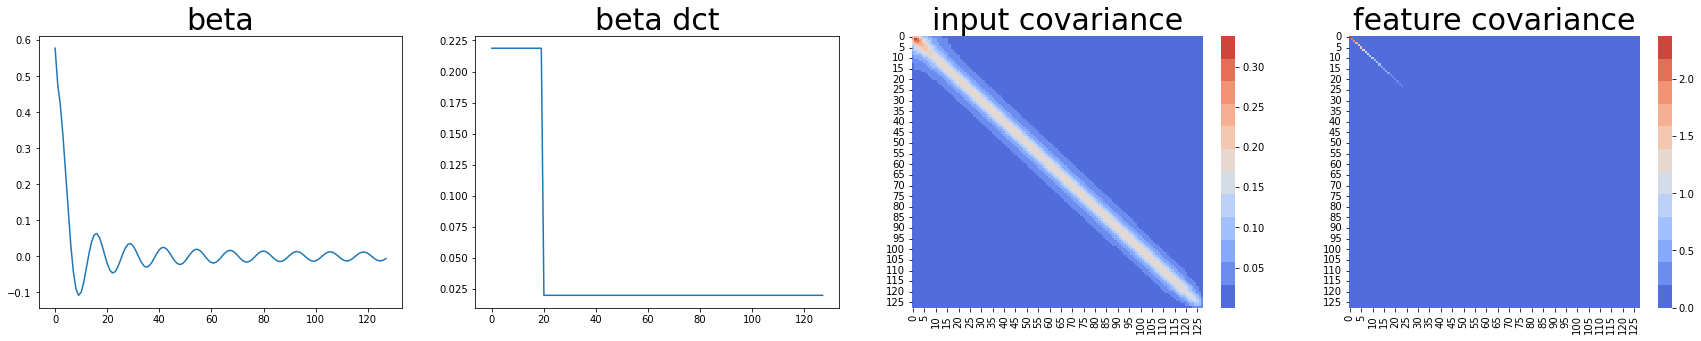

In [525]:
plt.figure(figsize=(30, 5))
plt.subplot(1,4,1)
plt.plot(betaStar)
plt.title("beta", fontsize=30)
plt.subplot(1,4,2)
plt.plot(coef)
plt.title("beta dct", fontsize=30)

xis = np.linspace(5, ambientDimension, 5)
ax = plt.subplot(1,4,3)
sns.heatmap(featureCov, cmap=sns.color_palette("coolwarm", 12), ax=ax)
ax.set_title('input covariance', fontsize=30)
ax = plt.subplot(1,4,4)
sns.heatmap(U.T.dot(featureCov).dot(U), cmap=sns.color_palette("coolwarm", 12), ax=ax)
ax.set_title('feature covariance', fontsize=30)

plt.show()

In [526]:
snr = (LA.norm(betaStar))**4 / betaStar.T.dot(featureCov).dot(betaStar)[0][0]
print(f"SNR = {snr}")

SNR = 0.9999999999999998
